In [85]:
import numpy as np
import pandas as pd
import cvxpy as cp
import random
from matplotlib import pyplot as plt
from pandas.io.pytables import performance_doc


class MyClassifier_25:  

    def __init__(self,dataset,class1:int,class2:int,algo=2) -> None:
    
    # ~~~~~~~~~~~~~~~~~~ VARIABLES THAT SHOULD NOT BE CHANGED ~~~~~~~~~~~~~~~~~~~~~~
        self.w = None
        self.b = None
        self.w_hist = None
        self.b_hist = None
        self.classes = { 1 : class1, -1: class2, 0:None}
        self.dataset_train = dataset

        #data prep
        self.trainlabel,self.traindata = self.prepare_binary(self.dataset_train)
        self.yet_to_train_dataset = self.dataset_train
        self.sampled_dataset = None
        
        self.i = 0 # Dataset Iterator 
        self.sel_arr = np.zeros(self.traindata.shape[0]) # Binary Array indicating whether a sample -
                     # is selected or not in order of sample selection and not dataset index
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~ VARIABLES YOU CAN CHANGE ~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        # End Iteration
        self.iter_end = 1500 # Set it very high if you want to execute over entire dataset
        
        # Debug Mode - Executes print statements if true
        self.debug_mode = False
        
        # Algorithms:
        # 1.Percentage Random Batch Sampling
        # 2.Epsilon Greedy Sampling
        self.aglo_sel = algo #Set to 2 by default
        
        # Percentage Random Batch Sampling Variables:
        # This algo will collect (iter_end * perct_sel_smpls) no. of samples
        self.perct_sel_smpls = 0.3 # percentage of Selected samples from dataset DEFAULT VALUE
        self.batch_size = 100 # Batch Size for samples
        self.mini_batch_size = 20 # Mini Batch Size for samples
        self.mini_batch_slots_to_be_filled = int(self.perct_sel_smpls * self.mini_batch_size)
        self.batch_slots_to_be_filled = int(self.perct_sel_smpls * self.batch_size)
        
        # Epsilon Greedy Sampling Variables:
        # This algo will collect (sampling_requirement + 1) no. of samples
        self.initial_sample_size = self.batch_size
        self.epsilon_out = 0.4
        self.epsilon_sv = 0.7
        self.sampling_requirement = 1000
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ FUNCTION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Classifier Function
        self.selection_and_train()
    
# ~~~~~~~~~~~~~~~~~~~~~~~~ FUNCTIONS IN ORDER OF EXECUTION ~~~~~~~~~~~~~~~~~~~~~~~~~~~

    def selection_and_train(self,select_samples_percent=0.5):
        # OPTIONS
        # 1. Over entire dataset via some percentage sampling
        # 2. Until value converges then switch to rejecting more than accepting and stop taking big batches

        self.i = 0 # Dataset Iterator 
        self.sample_counter = 0
        self.mini_batch_slots_to_be_filled = int(select_samples_percent * self.mini_batch_size)
        self.batch_slots_to_be_filled = int(select_samples_percent * self.batch_size)
        
        # Iterate over dataset until it is exhausted (or converged then switch state)
        while(self.i<self.sel_arr.size-1):
        
            # Sample and remove the sample from the dataset (to avoid duplicates in future sampling)
            sample = self.yet_to_train_dataset.sample(n=1)
            self.yet_to_train_dataset.drop(sample.index)
            
            # Perform next steps if sample selection is true
            if self.sample_selection(sample) is True:
                print("Sample is accepted") if self.debug_mode is True else None
                self.sample_counter +=1
                if self.sampled_dataset is None:
                    self.sampled_dataset = sample
                else:
                    self.sampled_dataset = self.sampled_dataset.append(sample, ignore_index=True)
                #print("tail:",self.sampled_dataset.tail)
                #print("shape:",self.sampled_dataset.shape)
                self.sel_arr[self.i] = 1 # mark as sampled
                
                # Train Sample if batch size is reached
                if (self.sample_counter % self.batch_size) == 0 and (self.sample_counter != 0):
                    lbl, dt = self.prepare_binary(self.sampled_dataset)
                    self.train(dt,lbl)
                    self.store_w_b()
            
            self.i+=1
            if self.i>self.iter_end:
                break
        lbl, dt = self.prepare_binary(self.sampled_dataset)
        self.train(dt,lbl)
        
    def sample_selection(self,training_sample):
        # This method accepts only 1 random training sample at a time and decides whether to send it or not
        # Returns True if sample is accepted and False otherwise
        # return True if accept_sample == 1 else False
        
        # INITIALIZE RANDOM SAMPLING=======================================
        accept_sample = random.randint(0, 1)
        
        
        # ALGORITHM
        # TYPES OF SAMPLING================================================
        if self.aglo_sel == 1:
            accept_sample = self.mini_batch_sampling()
        elif self.aglo_sel == 2:
            accept_sample = self.scheduler_sampling(training_sample)
        else:
            accept_sample = random.randint(0, 1)
        
        if(self.i==0):
            accept_sample = random.randint(0, 1)
        
        # print("accept_sample: ",accept_sample)
        print("~~~~~~~~~~~~~~~~~~~~~~~~") if self.debug_mode is True else None
        print("# ",self.i) if self.debug_mode is True else None
        print("Inside Sample Selection,") if self.debug_mode is True else None
        print("Number of accepted samples: ",self.sample_counter," current accepted: ",accept_sample) if self.debug_mode is True else None
        # Returns True if sample is accepted and False otherwise
        return True if accept_sample == 1 else False

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  ALGORITHM FUNCTIONS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~ 1.Percentage Random Batch Sampling ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    def mini_batch_sampling(self):
        accept_sample = random.randint(0, 1)
        mini_start = (self.i // self.mini_batch_size)*self.mini_batch_size
        mini_end = mini_start + (self.i % self.mini_batch_size) + 1

        print("mini_start: ",mini_start,"mini_end: ", mini_end) if self.debug_mode is True else None
        print("Mini Batch: ",self.sel_arr[mini_start:mini_end]) if self.debug_mode is True else None

        # MINI BATCH  --------------------------------------------------------------
        # No. of mini batch and batch slots that must be filled to satisfy percentage criteria
        mini_batch_count = np.count_nonzero(self.sel_arr[mini_start:mini_end])
        if mini_batch_count >= self.mini_batch_slots_to_be_filled:
            accept_sample = 0
        
        print("If Mini Batch Count: ",mini_batch_count," >= mini slots ",self.mini_batch_slots_to_be_filled," then 0") if self.debug_mode is True else None
            
        # Lower bound for mini batch percentage criteria
        if (self.i % self.mini_batch_size) >= (self.mini_batch_size - self.mini_batch_slots_to_be_filled) and mini_batch_count <self.mini_batch_slots_to_be_filled:
            accept_sample = 1
        
        print("If Mini Batch iterator: ",self.i % self.mini_batch_size," >= rem mini slots ",self.mini_batch_size - self.mini_batch_slots_to_be_filled, "and Mini Batch Count: ",mini_batch_count," < mini slots ",self.mini_batch_slots_to_be_filled," then 1") if self.debug_mode is True else None

        # BATCH ------------------------------------------------
        ### BATCH SIZE INFORMATION HAS TO COME FROM CENTRAL NODE
        start = (self.i // self.batch_size)*self.batch_size
        end = start + (self.i % self.batch_size) + 1
        batch_count = np.count_nonzero(self.sel_arr[start:end])
        if batch_count >= self.batch_slots_to_be_filled:
            accept_sample = 0
        
        print("start: ",start,"end: ", end) if self.debug_mode is True else None
        print("Batch: ",self.sel_arr[start:end]) if self.debug_mode is True else None
        print("If Batch Count: ",batch_count," >= slots ",self.batch_slots_to_be_filled, " then 0") if self.debug_mode is True else None
        # Lower bound for batch percentage criteria
        print("If Batch iterator: ",self.i % self.batch_size," >= rem slots ",self.batch_size - self.batch_slots_to_be_filled, "and Batch Count: ",batch_count," < slots ",self.batch_slots_to_be_filled, " then 1") if self.debug_mode is True else None

        if (self.i % self.batch_size) >= (self.batch_size - self.batch_slots_to_be_filled) and batch_count < self.batch_slots_to_be_filled:
            accept_sample = 1

        return accept_sample

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 2.Epsilon Greedy Sampling ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# https://arxiv.org/pdf/2104.02822.pdf   -- maybe try later

    def scheduler_sampling(self,training_sample):
        n = self.initial_sample_size # Set it at the top
        
        # Accept first n samples
        if self.sample_counter < n:
            accept_sample = 1   
            
        elif self.sample_counter >= n and self.sample_counter < 2*n:
            accept_sample = self.region_compute(training_sample)

        elif self.sample_counter >= 2*n and self.sample_counter < 3*n:
            accept_sample =1

        elif self.sample_counter >= 3*n:
            accept_sample = self.region_compute(training_sample)
        
        else:
            accept_sample = 0
        
        # Restriction of number of samples:
        if self.sample_counter > self.sampling_requirement:
            accept_sample = 0
        elif self.iter_end - self.i < self.sampling_requirement - self.sample_counter:
            accept_sample = 1
            
        return accept_sample
    
    def region_compute(self,sample):
        retval = 0
        smpl_lbl,smpl_dt= self.prepare_binary(sample)
        r = self.region(test_input=smpl_dt) # distance function
        if r == 1 or r == -1:  
            # P3 or P1 REGION
            # Test the label data with the prediction
            for key, val in self.classes.items():
                if val == sample['label'].values[0]:
                    cls = key
            print("cls: ",cls) if self.debug_mode is True else None
            if cls == r:
                # if correct it will reinforce the current hyperplane
                # REINFORCE WITH PROBABILITY EPSILON
                retval = self.epsilon_greedy(self.epsilon_out)
            else:
                # if incorrect now make the call to keep it or not -> it will change hyperplane
                # CHANGE WITH PROBABILITY 1-EPSILON
                retval = self.epsilon_greedy(1-self.epsilon_out)
            
        if r != -1 or r != 1:
            # MUDDY PREDICTION --> most impact
            # in the P2 region take this sample -> r is the distance from the hyperplane
            retval = self.epsilon_greedy(self.epsilon_sv)
        
        return retval
    
    def epsilon_greedy(self,eps):
        # Another type of sampling
        p = np.random.randn()
        if p < eps:
            return 1
        else:
            return 0
        
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TRAIN FUNCTION ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    def train(self,traindata,trainlabel):
        
        #USAGE
        # W, w = train(traindata, trainlabel)

        # m: Number of feature vectors
        # W and w: Weight vector and Bias value respectively
        print("STARTING TRAINING. DATA SIZE    ",traindata.shape) if self.debug_mode is True else None
        m = traindata.shape[1]
        W = cp.Variable((m,1))
        w = cp.Variable()
        prob = self._hinge_loss_svm(traindata,trainlabel,W,w)
        prob.solve()
        # Solving the problem would give us the optimal values from W and w;
        # which have to be returned, so that we can use them while testing
        ## adding to class variable
        self.w = W
        self.b = w
        print("============================TRAINED==========================") if self.debug_mode is True else None
    
    def _hinge_loss_svm(self,traindata, trainlabel,W,w):
        m =traindata.shape[1]
        # Equation for the regularizer.
        # It is the lambda*(norm2 of W)**2
        # Here "lambda" is a non negative constant
        lambd = cp.Parameter(nonneg=True)

        ## Ideally we will have to try using different values fro "lambda"
        ## For the sake of testing the code, we have set it to 0.01
        ## Do we need to have a lambda?
        lambd = 0.01 
        reg_loss = cp.norm(W,p=2)**2
        
        #hinge loss
        hinge_loss = cp.sum(cp.pos(1-cp.multiply(trainlabel,traindata @ W - w)))
        
        #Objective is to minimize reg_loss and hinge_loss
        # objective_func = cp.Minimize(hinge_loss/m + lambd*reg_loss)
        prob = cp.Problem(cp.Minimize(hinge_loss/m + lambd*reg_loss))
        # Now framing the LP, along with the constraints
        return prob
    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ OTHER FUNCTIONS USED IN SAMPLE SELECTION AND TRAIN ~~~~~~~~~~~~~~~
    
    def prepare_binary(self,dataset):
        #USAGE    
        # Since we have to deal with a binary classifier to diffrentiate between digits 7 and 1, 
        # we choose only those examples.
        # If asked to train a classifier on any other pair a, b (say),
        # please pass the right arguments to the following function as follows:
        # trainlabel, traindata, dataTargetDf = prepare_binary(a,b)


        # We now assign +1 to one class and -1 to the other;
        # Therefore +1 and -1 will be the new labels
        class1 = self.classes[1]
        class2 = self.classes[-1]

        trainlabel = dataset.loc[(dataset['label']== class1)  | (dataset['label']== class2) ]['label']
        trainlabel.loc[trainlabel == class1] = 1
        trainlabel.loc[trainlabel == class2] = -1
        trainlabel = trainlabel.to_numpy()
    
        #In order to match dimensions of "traindata" and "trainlabel", we convert trainlabel to two dimension array
        # for hinge loss
        trainlabel= np.reshape(trainlabel, (trainlabel.shape[0],1))   

        # We now extract the features for the two classes
        traindata = dataset.loc[(dataset['label']== class1)  | (dataset['label']== class2) ]
        traindata = traindata.drop(labels = ["label"],axis = 1)
        traindata = traindata.to_numpy()

        return trainlabel, traindata
    
    def region(self,test_input,w=None,b=None):
        if w is None:
            w = self.w.value
        if b is None:
            b = self.b.value
        r = self.dist(test_input,w,b)
        if r < -1:
            return -1
        elif r > 1:
            return 1
        else:
            return r
        
    def dist(self,test_input,w=None,b=None):
        if w is None:
            w = self.w.value
        if b is None:
            b = self.b.value
        dist_val = test_input.dot(w) -  b
        return dist_val.item()
    
    def store_w_b(self):
        # Store the w and b values each time, classifier is trained
        if self.w_hist is None:
            self.w_hist = self.w.value
            self.b_hist = np.reshape(np.array([self.b.value]),[-1,1])

        else:
            self.w_hist = np.hstack((self.w_hist,self.w.value))
            self.b_hist = np.hstack((self.b_hist,np.reshape(np.array([self.b.value]),[-1,1])))

        return None

# ~~~~~~~~~~~~~~ TEST AND PLOT FUNCTIONS (USED SEPARATELY ie: not called in sample selection and train) ~~~~~~~~~~~

    def test(self,dataset_test,w=None,b=None):
        if w is None:
            w = self.w.value
        if b is None:
            b = self.b.value
        testlabel,testdata= self.prepare_binary(dataset_test)
        res = []
        performance = 0
        for i in range(testdata.shape[0]):
            result = self.f(testdata[i],w,b)
            res.append(result)
            
            actual_class = self.classes.get(int(testlabel[i]))
            ## assessing performance
            if result == actual_class:
                performance += 1 
        performance /= testlabel.shape[0]
        return res, performance

    
    def plot_classifier_performance_vs_number_of_samples(self, dataset_test, to_plot = True):
        
        r_hist = None
        p_hist = None
        
        for it in range(0,self.w_hist.shape[1]):
            res, performance = self.test(dataset_test,np.reshape(my_clf.w_hist[:,it],[-1,1]),np.reshape(my_clf.b_hist[:,it],[-1,1]))
            if r_hist is None and p_hist is None:
                r_hist,p_hist = res,performance
            else:
                r_hist = np.append(r_hist,res)
                p_hist = np.append(p_hist,performance)
        y = p_hist.tolist()
        x = range(self.batch_size,self.batch_size*(self.sample_counter//self.batch_size+1),self.batch_size)
        if to_plot == True:
            plt.plot(x,y)
        
        return x,y

    def f(self,test_input,w=None,b=None):
        if w is None:
            w = self.w.value
        if b is None:
            b = self.b.value
        test_val =  self.region(test_input,w,b)
        if test_val == -1 or test_val == 1:
            test_val = test_val
        else:
            test_val = 0
        estimated_class = self.classes.get(test_val)
        return estimated_class
    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ UNUSED FUNCTIONS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    def reset_training_dataset(self):
        self.yet_to_train_dataset = self.dataset_train
        self.sampled_dataset = None
        
        self.i = 0 # Dataset Iterator 
        self.sel_arr = np.zeros(self.traindata.shape[0]) # Binary Array indicating whether a sample -
                     # is selected or not in order of sample selection and not dataset index

    def train_different_sample_sizes_and_store_performance(self,list_of_samples):
        test_dataset = pd.read_csv('mnist/mnist_test.csv')
        correctness = []
        for percent_sampling in list_of_samples:
            self.selection_and_train(select_samples_percent=percent_sampling)
            res,performance = self.test(test_dataset)
            correctness.append(performance)
            
        return correctness
    
    def target_df(self,traindata,trainlabel):
        # Also creating a dataframe with these, so that we can randomize the order of the train data when needed without
        # losing the mapping between feature vectors and the target labels
        trainDf=pd.DataFrame(traindata)
        targetDf=pd.DataFrame(trainlabel,columns=['target'])
        
        dataTargetDf = pd.concat([trainDf, targetDf[['target']]], axis = 1)
        ##If randomizing the order, should we use the dataframe 'finalDf'?
        return dataTargetDf

    def subset(self,dataTargetDf, subsetfrac:float):
        
        # Usage: If 20% of the data is to be randomly selected
        # subsetDf = subset(dataTargetDf, 0.2)
        
        return dataTargetDf.sample(frac = subsetfrac)
    
    def _normal_loss_svm(self,traindata,trainlabel, W,w):
        #Constraint
        # For every feature vector traindata[i] and its corresponding label trainlabel[i]:
        # W^T*traindata[i] + w >= 1
        const = [trainlabel[i]*(traindata[i]@ W + w) >= 1 for i in range(traindata.shape[0])]
        ##Check the dimensions in the above constraint equation
        
        #Objective is to minimize reg_loss and hinge_loss
        # objective_func = cp.Minimize(hinge_loss/m + lambd*reg_loss)
        objective_func = cp.Minimize(0.5*cp.norm(W,p=2)**2)
        prob = cp.Problem(objective_func,constraints=const)
        
        # Now framing the LP, along with the constraints
        return prob
    
    def assess_classifier_performance(self,performance):
        performance = np.asarray(performance)
        correct = (np.count_nonzero(performance)/len(performance))*100
        
        return correct
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ END OF CLASS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [94]:
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

mnist_train = pd.read_csv("train.csv")
mnist_test = pd.read_csv("mnist_test.csv")
#Take copies of the master dataframes

train = mnist_train.copy()
tester = mnist_test.copy()
tester = tester.loc[tester['label'].isin([4,9])]

train_class_1 = train.loc[train['label'] == 4]
train_class_2 = train.loc[train['label'] == 9]
train = train.loc[train['label'].isin([4,9])]
train_rdm = train.sample(frac = 0.5)
test_rdm = train.sample(frac = 0.2)


In [95]:
my_clf = MyClassifier_25(train,4,9)
res, performance = my_clf.test(test_rdm)

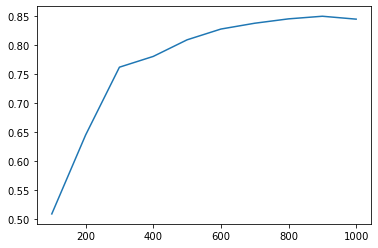

In [96]:
x,y = my_clf.plot_classifier_performance_vs_number_of_samples(tester)

In [97]:
x

range(100, 1100, 100)

In [98]:
y

[0.5092918131592165,
 0.6454043194374686,
 0.7624309392265194,
 0.7810145655449523,
 0.8096433952787544,
 0.8282270215971873,
 0.8382722250125565,
 0.8458061275740834,
 0.8503264691109995,
 0.8453038674033149]

In [99]:
my_clf.sample_counter

1001

In [100]:
my_clf.sampling_requirement

1000

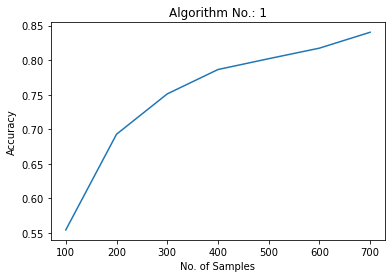

Avg: [0.5543947764942241, 0.6928176795580111, 0.7511803114013059, 0.7864389753892517, 0.8021094927172274, 0.8173782019085888, 0.8403817177297841]


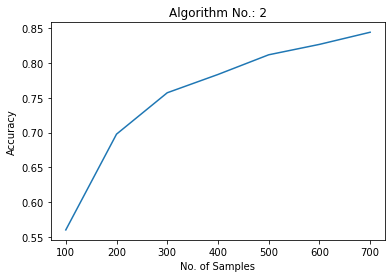

Avg: [0.5600200904068308, 0.6978402812656956, 0.7574083375188347, 0.783726770467102, 0.812054244098443, 0.827021597187343, 0.8445002511300854]


In [109]:
# Testing the Algorithm performance by averaging from 10 classifiers
num = 5
min_len = 100
# Outer Loop for algorithm
for i in range(1,3):
    # Inner Loop for averaging accuracy performance
    avg = None
    for j in range (num):
        my_clf = MyClassifier_25(train,4,9,i)
        x,y = my_clf.plot_classifier_performance_vs_number_of_samples(tester,False)
        if avg is None:
            avg = y
        else:
            avg = np.add(np.array(avg),np.array(y)).tolist()
    avg = (np.array(avg) / num).tolist()
    if min_len > len(avg):
        min_len = len(avg)
    if min_len < len(avg):
        avg = avg[0:min_len]
        x = range(my_clf.batch_size,(min_len+1)*my_clf.batch_size,my_clf.batch_size)
    plt.plot(x,avg)
    plt.title("Algorithm No.: %i"%i)
    plt.xlabel("No. of Samples")
    plt.ylabel("Accuracy")
    plt.show()
    print("Avg:",avg)